In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
import tabulate
import math
import seaborn as sns

# changed display options to accomodate for long list in output
# pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 2000)

In [2]:
# can load ~1/3 of dataset so will split into 3 chunks
n_chunks=5

# total num of rows in OG file
n_rows=sum(1 for row in open('train.csv')) -1 # subtract header row

chunk_size=n_rows // n_chunks

## Prep Parameters

In [3]:
chunk = next(pd.read_csv('train.csv', chunksize=chunk_size, low_memory=False))
print(f'chunk shape - before : {chunk.shape}')

# drop col with NA > than threshold (50%)
NA_thresh = 0.5
# outlier threshold
out_thresh=3

# define features
cat_col=chunk.select_dtypes(include='object').columns
time_col=['VAR_0073','VAR_0075','VAR_0156','VAR_0157',
          'VAR_0158','VAR_0159','VAR_0166','VAR_0167','VAR_0168','VAR_0169',
           'VAR_0176','VAR_0177','VAR_0178','VAR_0179','VAR_0204','VAR_0217','VAR_0314','VAR_0531']
num_col=chunk.select_dtypes(include=np.number).columns.difference(time_col)


def prep(df):
    # operationalize NA values
    df=df.replace(['-1','[]'], np.nan)
    
    # drop col with only 1 unique value (doesn't provid variability)
    dropped_col={}
    unique_count=df.nunique(dropna=True)
    nonunique_col=unique_count[unique_count<=1].index
    dropped_col['nonunique_col']={col: df[col].dropna().unique() for col in nonunique_col}
    df=df.drop(nonunique_col, axis=1)
    print(f'columns with a single unique value dropped: {dropped_col}')
    
    # drop outliers based on outlier threshold

    
    # convert string to standard datetime format
    for col in time_col:
        try:
            df[col]=pd.to_datetime(df[col], errors='coerce', format='%d%b%y:%H:%M:%S')
        except ValueError:
            print(f'trouble converting column(s) {col} to datetime')
        else:
            print('\ndatetime columns have been successfully converted')
                                  
    # duplicates
    duplicates=df.duplicated().sum()
    print(f'\nnumber of duplicates - before: {duplicates}')
    df=df.drop_duplicates()
    print(f'number of duplicates - after: {duplicates}')
    
    return df

prepped_ck=prep(chunk)
print(f'chunk shape - after : {prepped_ck.shape}')

chunk shape - before : (29046, 1934)


/tmp/ipykernel_340/226561056.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df=df.replace(['-1','[]'], np.nan)


columns with a single unique value dropped: {'nonunique_col': {'VAR_0008': array([False], dtype=object), 'VAR_0009': array([False], dtype=object), 'VAR_0010': array([False], dtype=object), 'VAR_0011': array([False], dtype=object), 'VAR_0012': array([False], dtype=object), 'VAR_0018': array([0.]), 'VAR_0019': array([0.]), 'VAR_0020': array([0.]), 'VAR_0021': array([0.]), 'VAR_0022': array([0.]), 'VAR_0023': array([0.]), 'VAR_0024': array([0.]), 'VAR_0025': array([0.]), 'VAR_0026': array([0.]), 'VAR_0027': array([0.]), 'VAR_0028': array([0.]), 'VAR_0029': array([0.]), 'VAR_0030': array([0.]), 'VAR_0031': array([0.]), 'VAR_0032': array([0.]), 'VAR_0038': array([0.]), 'VAR_0039': array([0.]), 'VAR_0040': array([0.]), 'VAR_0041': array([0.]), 'VAR_0042': array([0.]), 'VAR_0043': array([False], dtype=object), 'VAR_0044': array([], dtype=float64), 'VAR_0106': array([0.]), 'VAR_0188': array([0.]), 'VAR_0189': array([0.]), 'VAR_0190': array([0.]), 'VAR_0191': array([0.]), 'VAR_0196': array([Fal

## 1. Missing Values

In [6]:
def NA(df,NA_thresh):
    # drop cols with NA values above threshold
    na_count=df.isna().sum()
    drop_col=na_count[na_count / len(df) > NA_thresh].index
    df=df.drop(drop_col, axis=1)
    
    # Impute
    imputed_ck=df.copy()
    
    # impute numerical col with mean
    for col in num_col:
        if col in imputed_ck.columns:
            imputed_ck[col].fillna(imputed_ck[col].mean(), inplace=True)
        
    # impute categorical col with mode
    for col in cat_col:
        if col in imputed_ck.columns and not imputed_ck[col].mode().empty:
            imputed_ck[col].fillna(imputed_ck[col].mode()[0], inplace=True)
        
    # Convert time columns to datetime
    for col in time_col:
        try:
            imputed_ck[col] = pd.to_datetime(imputed_ck[col], errors='coerce', format='%d%b%y:%H:%M:%S')
        except ValueError:
            print(f'Trouble converting column {col} to datetime')    
        
    # impute time col with median
    for col in time_col:
        if col in imputed_ck.columns:
            imputed_ck[col].fillna(imputed_ck[col].median(), inplace=True)
        
    return imputed_ck

print(f'number of NA - before: {np.any(chunk.isnull())}')

prepped_ck=NA(chunk,NA_thresh)

print(f'number of NA - after: {np.any(chunk.isnull())}')

prepped_ck

print(prepped_ck.shape)

number of NA - before: True


/tmp/ipykernel_340/2776896027.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_ck[col].fillna(imputed_ck[col].mean(), inplace=True)
/tmp/ipykernel_340/2776896027.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

KeyError: 'VAR_0073'

Having problems with converting time columns to to datetime -- can't impute

separate question, how should datetime objects be imputed?

## 2. Data Visualization

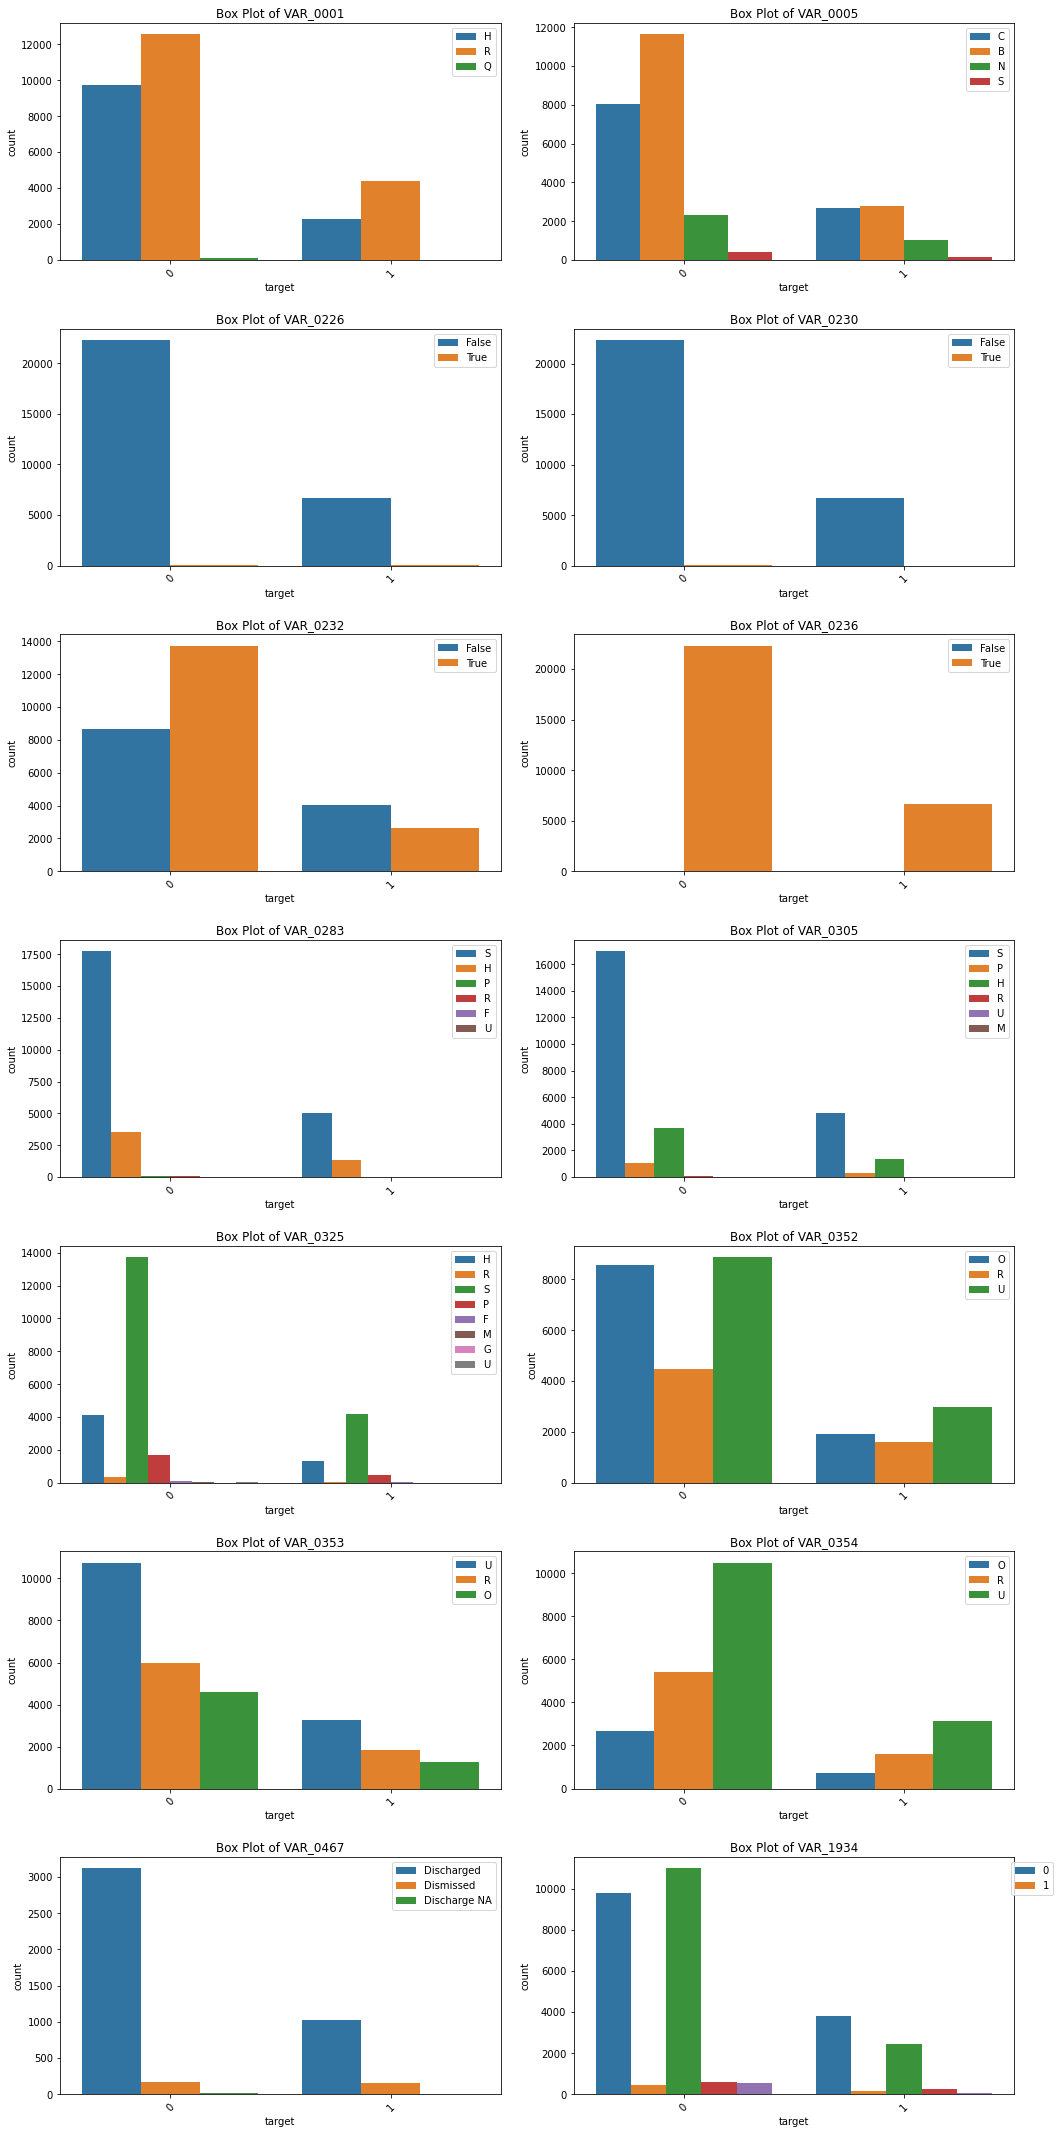

In [26]:
# Extract only the categorical columns
max_values = 30
categorical_cols = [col for col in prepped_ck.select_dtypes(include=['object']).columns if prepped_ck[col].nunique() <= max_values]

# Define the target column name
target_col = 'target' 

# Filter the DataFrame for each class
df_0 = prepped_ck[prepped_ck[target_col] == 0] 
df_1 = prepped_ck[prepped_ck[target_col] == 1]

# number of subplots
n = len(categorical_cols)
n_cols = 2
n_rows = math.ceil(n/n_cols)

# Create a grid of box plots for categorical columns for each class
plt.figure(figsize=(15, 30))
for i, col in enumerate(categorical_cols, 1):
    if col in time_col:
        continue # skip time cols
        
    plt.subplot(n_rows, n_cols, i)  # Adjust the subplot layout based on the number of categorical columns
    sns.countplot(data = prepped_ck, x = target_col, hue = col)
    plt.title(f'Box Plot of {col}')
    plt.xticks(rotation=45)
    plt.legend()
    
plt.legend(['0', '1'], loc='upper right', bbox_to_anchor=(1.1, 1))

plt.tight_layout(pad=2.0)
plt.show()

/tmp/ipykernel_340/2340332374.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=3.0)  # Adjust padding between subplots


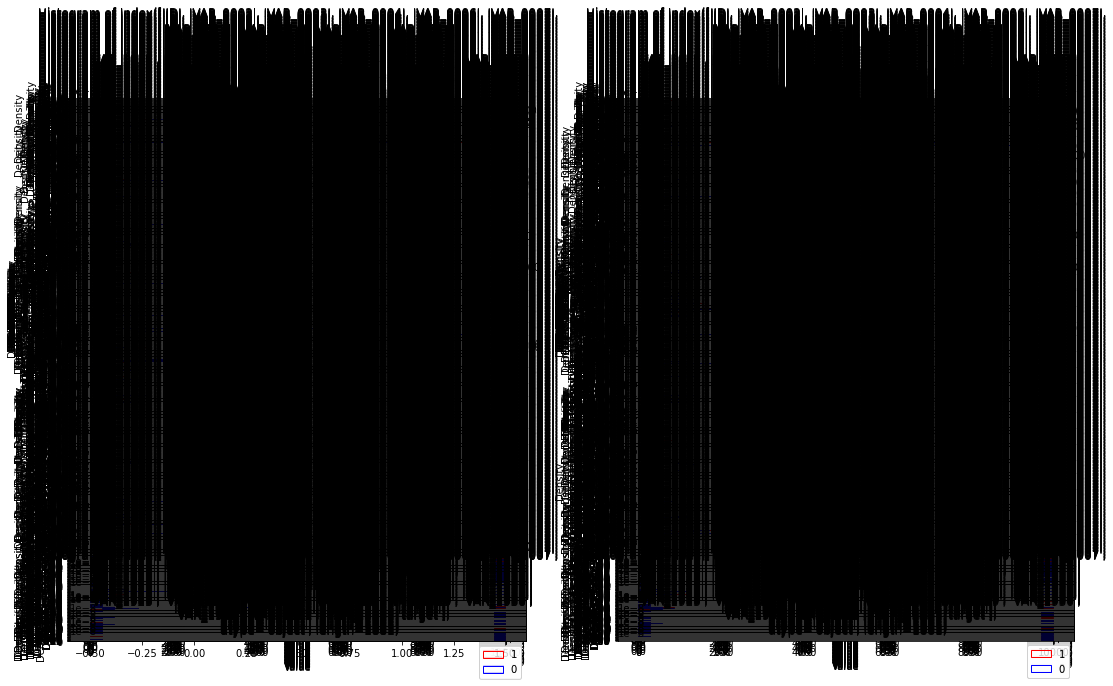

In [31]:
numerical_col=prepped_ck.select_dtypes(include=np.number).columns.difference(time_col)

# Define the target column name
target_col = 'target' 

# Filter the DataFrame for each class
df_0 = prepped_ck[prepped_ck[target_col] == 0] 
df_1 = prepped_ck[prepped_ck[target_col] == 1]

# Define the number of columns and rows for subplots
n_cols = 2 
n_rows = (len(numerical_col) + 1) // n_cols  # Number of rows in the grid

# Create a grid of histograms for numerical columns
plt.figure(figsize=(18, 10))

for i, num in enumerate(numerical_col, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(np.array(df_1[num]), bins=35, histtype="step", color="red", label="1", density=True, stacked=True)
    plt.hist(np.array(df_0[num]), bins=35, histtype="step", color="blue", label="0", density=True, stacked=True)
    plt.title(f'Histogram of {num_col}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(loc='upper right')

plt.tight_layout(pad=3.0)  # Adjust padding between subplots
plt.show()

Can group numerical categories into object-type columns (categorical), ex) can group states into region, or group numerical features with very few values into categorical features.

When graph works check for columns that are constant and drop.
If cannot get graph to work, resort to pairplot and heatmap (either way visualize with heatmap to check correlation and aid in feature selection).

Check for potential NA values (99.0, 999,999,999, and some negative numbers).
Check and deal with outliers.

Standardize or normalize if data is skewed & encode.